In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe

In [2]:
# Open and rename data
filepath = 'fcst_column.pwat_cw.reg_tl319.2003-2005.nc'
sat_ds = xr.open_dataset(filepath)
var=sat_ds['cw']
var=var.rename({'j': 'x', 'i': 'y'})
var

<xarray.DataArray 'cw' (time: 1095, x: 320, y: 640)>
[224256000 values with dtype=float64]
Dimensions without coordinates: time, x, y

In [3]:
# Read in input lat and lon info 
JRA_ds_coord_file = xr.open_dataset('JRA-55_lats_lons.nc')
JRA_lat=JRA_ds_coord_file.lat
JRA_lon=JRA_ds_coord_file.lon

JRA_lat = JRA_lat.rename({'i': 'x'})
JRA_lon = JRA_lon.rename({'j': 'y'})

# Assign input lat/lon to variable
var=var.assign_coords({"lon": JRA_lon, "lat":JRA_lat})
var

<xarray.DataArray 'cw' (time: 1095, x: 320, y: 640)>
[224256000 values with dtype=float64]
Coordinates:
    lon      (y) float64 ...
    lat      (x) float64 ...
Dimensions without coordinates: time, x, y

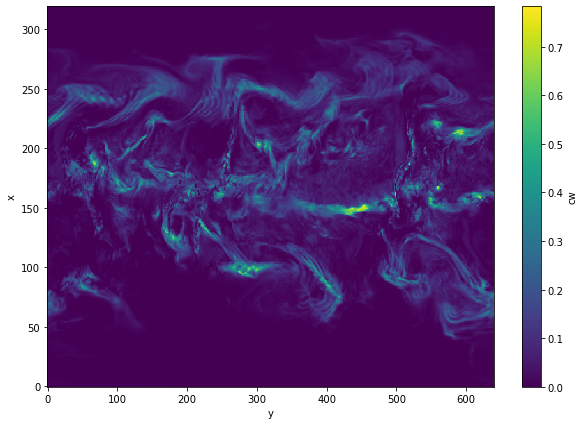

In [4]:
# Plot one timestep of original data as an example
fig, ax = plt.subplots(figsize=(10,7))
var[0,:,:].plot(ax=ax)
#fig.savefig('orig_grid.pdf')  

In [5]:
# Read in output lat/lon info from a CAM file 
ds_out_file = xr.open_dataset('sfcWind_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc')
ds_out = xr.Dataset({
    'lon': ds_out_file.lon,
    'lat': ds_out_file.lat
})
ds_out

/Users/abby/anaconda3/envs/hannah_xesmf_env/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'sfcWind' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Data variables:
    *empty*

In [6]:
# Regridder function with options for method and reusing weight files
regridder = xe.Regridder(var, ds_out, 'nearest_s2d', reuse_weights=False)
regridder

Create weight file: nearest_s2d_320x640_192x288.nc


xESMF Regridder 
Regridding algorithm:       nearest_s2d 
Weight filename:            nearest_s2d_320x640_192x288.nc 
Reuse pre-computed weights? True 
Input grid shape:           (320, 640) 
Output grid shape:          (192, 288) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [7]:
dr_out = regridder(var)
dr_out

<xarray.DataArray 'cw' (time: 1095, lat: 192, lon: 288)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.00435638, 0.00470734, 0.00505066, ..., 0.0035553 ,
         0.00391388, 0.0041275 ],
        [0.00048828, 0.00055695, 0.00061035, ..., 0.00033569,
         0.00039673, 0.00045013],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.00218964, 0.00221252, 0.00223541, ..., 0

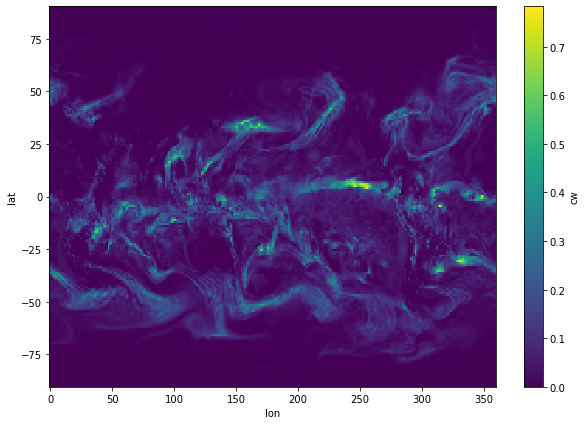

In [8]:
# Plot one timestep of regridded data as an example
fig2, ax2 = plt.subplots(figsize=(10,7))
dr_out[0,:,:].plot()
#fig2.savefig('new_grid.pdf')  

In [9]:
# Save regridded data to a netcdf file 
ds=xr.Dataset()
ds['cw']=(('time','y','x'),dr_out)
ds.coords['lat']=(('y'), ds_out['lat'])
ds.coords['lon']=(('x'),ds_out['lon'])
#ds.coords['time']=(('time'),sic_rg['time'])
#Add whatever attributes you want to document your output
ds['cw'].attrs['units']='kg/m2'
ds.attrs['Description']='JRA-55 data regridded onto a different rectilinear grid'
svdirec='/satellite_data_regridding/'
ds.to_netcdf(path=svdirec+'JRA-55_cw_xesmf_rg_2003_2005.nc')